# A/B Test Analysis

#### By Eelke Brouwers

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
## Introduction

Analyzing the results of an A/B test run by an e-commerce website. Aim is to advise on whether they should: 
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer before making a decision.

Description of the dataset:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

<a id='probability'></a>
## Part I - Probability

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

### Assessing data

In [3]:
# Read in dataframe
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# Number of rows in the dataset
df.shape[0]

294478

In [5]:
# Number of unique users in the dataset
df['user_id'].nunique()

290584

In [6]:
# Proportion of users that converted
# Conv contains all the individuals that converted
conv = df.query("converted == '1'")
conv.count()[0]/df.shape[0]

0.11965919355605512

In [7]:
# Create two queries, one for treatment and one for control
treatment = df.query("group == 'treatment'")
control = df.query("group == 'control'")

In [8]:
# Number of times the treatment group does not have a new page as 'landing_page'
pd.value_counts(treatment['landing_page'])[1] + pd.value_counts(control['landing_page'])[1]

3893

In [9]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [19]:
# Look for duplicates
df[df.duplicated(subset = ['user_id']) == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [20]:
# Display duplicates
df[df['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


#### Quality issues

1. Rows where the group and landing page do not match:
    - treatment - old page 
    - control - new page
2. Duplicated user IDs

## Data cleaning

In [21]:
# Created a new dataframe, df2  
df2 = df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


### Issue #1. Non-matching data 

#### Define
- Remove rows where the group and landing page do not match

#### Code

In [22]:
# Remove inaccurate rows of the treatment group
indexNames = df2[(df2['group'] == 'treatment') & (df2['landing_page'] == 'old_page')].index
df2.drop(indexNames, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [23]:
#Removed inaccurate rows of the control group
indexNames2 = df2[(df2['group'] == 'control') & (df2['landing_page'] == 'new_page')].index
df2.drop(indexNames2, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


#### Test

In [24]:
# Check if all of the incorrect rows were removed from df2 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### Issue #2. Duplicated row

#### Define
- Remove one of the rows with a duplicated user id.

#### Code

In [25]:
# Remove row with duplicated user_id
indexName = df2[df2.duplicated(subset = ['user_id']) == True].index
df2.drop(indexName, inplace=True)

#### Test

In [26]:
# Check whether deletion was succesful
df2[df2.duplicated(subset = ['user_id']) == True]

,user_id,timestamp,group,landing_page,converted


### Analysis 

#### What is the probability of an individual converting regardless of the page they receive?

In [27]:
# Conversion probability
p_population = df2[(df2['converted']==1)].shape[0]/df2.shape[0]
p_population

0.11959708724499628

In [28]:
# Conversion probability for the control group
control = df.query("group == 'control'")
ctrl_conv = df2[(df2['group']=='control') & (df2['converted']==1)].shape[0]/control.shape[0]
ctrl_conv

0.1203863045004612

In [29]:
# Conversion probability for the treatment group
treatment = df.query("group == 'treatment'")
treat_conv = df2[(df2['group']=='treatment') & (df2['converted']==1)].shape[0]/treatment.shape[0]
treat_conv

0.11880806551510564

In [30]:
# The difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treat_conv - ctrl_conv
obs_diff

-0.0015782389853555567

#### What is the probability that an individual received the new page?

In [31]:
# Probability an individual received the new page
prob_newpage = df2[df2['landing_page']=='new_page'].shape[0]/df2.shape[0]
prob_newpage

0.5000619442226688

> The new treatment group user did not lead to more conversions. For the new webpage the proportion of users who converted was actually slightly lower than for the old webpage group,  0.1188 and 0.1204 respectively.  

<a id='ab_test'></a>
## Part II - A/B Test

Our hypothesis assumes that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%: 

$H_0$: $p_{old}$ >= $p_{new}$ <br>
$H_1$: $p_{old}$ < $p_{new}$

### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, we assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, we assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: $p_{new}$ = $p_{old}$ = $p_{population}$


In [22]:
# Conversion rate for p-new, p-old and p-population
p_population

0.11959708724499628

In [24]:
# Size of the treatment group
n_new = df2[df2['group']=='treatment'].shape[0]
n_new

145310

In [25]:
# Size of the control group
n_old = df2[df2['group']=='control'].shape[0]
n_old

145274

**Simulate sample**

In [26]:
# Simulate sample for the treatment group
new_page_converted = np.random.choice([0,1], size = n_new, p=[(1-p_population), p_population])

In [27]:
# Simulate sample for the control group
old_page_converted = np.random.choice([0,1], size = n_old, p=[(1-p_population), p_population])

In [28]:
# Difference in the converted probability of the samples above
conv_p_diff = new_page_converted.mean()-old_page_converted.mean()
conv_p_diff

-0.00033230384231838772

**Sampling distribution** <br>

In [29]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    p_new = np.random.choice([0,1], size=n_new, p=[(1-p_population), p_population]).mean()
    p_old = np.random.choice([0,1], size=n_old, p=[(1-p_population), p_population]).mean()
    p_diffs.append(p_new-p_old)
p_diffs = np.array(p_diffs)

Text(0.5,0,'probability')

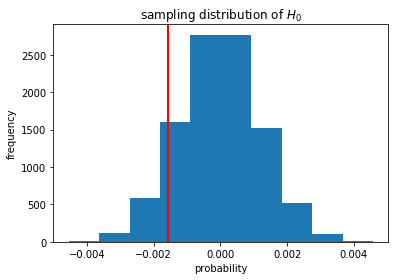

In [30]:
# Histogram of p_diffs
plt.hist(p_diffs)
plt.axvline(obs_diff, color='r', linewidth=2) # Plot the difference (obs_diff) between the conversion rates for the population
plt.title('sampling distribution of $H_0$')
plt.ylabel('frequency')
plt.xlabel('probability')

> The distribution centres around 0, which mean no difference between the converted success rate of the old and the new page users. This histogram is the distribution under the null hypothesis and appears normally distributed.

In [31]:
# Calculate P-value
(p_diffs>obs_diff).mean()

0.90180000000000005

> The P-value describes the likelihood the data have occured by random chance. The p-value is bigger than the "Type I error rate" (0.91>0.05). Based on these analysis we therefor fail to reject the null-hypothesis, meaning there is no difference between the new and old pages.


### Hypothesis Testing using Z-test<br>

In [32]:
import statsmodels.api as sm

# Number of conversions with the old_page
convert_old = control['converted'].sum()

# Number of conversions with the new_page
convert_new = treatment['converted'].sum()

# Number of individuals who were shown the old_page
n_old = control.shape[0]

# Number of individuals who received new_page
n_new = treatment.shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [33]:
# Z-test
count_array = np.array([convert_new, convert_old])
nobs_array = np.array([n_new, n_old])
z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


>The hypothesis I made is right-tailed, so therefor we would reject the null hypothesis if $Z_{score}$ > $Z_{\alpha}$. However, $Z_{score}$ < $Z_{\alpha}$ (-1.3109 < 1.645). We therefor do not reject the null hypothesis, meaning that the conversion rates of the old and new pages are similar, or higher for the old than the new pages. Also the p-value of 0.905 is not smaller than 0.05, leading to the same conclusion of not rejecting the null hypothesis. A similar conclusion was drawn from the null-hypothesis testing. 

<a id='regression'></a>
### Part III - A regression approach

As the response variable is qualitative we will use Logistic Regression. (Although, in this example, with conversion being a binary qualitative respons, a linear regression model is technically also possible. The two outcomes may then be treated as dummy variable: 1 for 'conversion' and 0 for 'no conversion'.) 

In [34]:
# Create dummies for group column
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('control', axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [35]:
# Fit logistic regression model 
lr = sm.Logit(df2['converted'], df[['intercept', 'ab_page']])
results = lr.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [36]:
# Result of the model above
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-12 11:59 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

>The p-value associated with ab_page is 0.1899. This p-value differs from the p-value in Part II because the result in logistic regression is two-sided (so the test assumes p_old and p_new to be the same under the null and to be different as the alternative hypothesis), while the hypothesis and result from part II is one-sided. This appears from dividing the p_value of ab_page by 2, which then becomes similar to the p-value of the z-test in part II. 

>**Thoughts on considering other factors to add into the regression model:**

>In short: adding (important) variables can improve our model fit, but overdoing can eventually lead to an overfit. 

>There may be multiple factors able to predict the respons variable. By choosing just one variable (single logistic regression) you may miss, or mask, correlations among predictors. For instance, let's say the factor country (introduced underneath) are correlated. You may pick up a difference in the single regression taking just the page into account, while it may actually be that the country a person is from is more accurate in predicting whether they convert or not. But because the two are correlated it may seem, based on single regression, that it is the page they saw that is strongly predicting the conversion. This is known as confounding. However, adding too many predicting variables can lead to overfitting. In that case the variables that are added are not really improving the model fit and can actually lead to poor results where coefficients start representing noise instead of the actual relationship between variables. 

**Adding factor 'countries'**<br> 

Here we add an effect based on which country a user lives in, focussing on the three countries UK, US and CA. 

In [38]:
# Read countries.csv
country = pd.read_csv('countries.csv')
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [39]:
# Join with the df2 dataframe
df_merged = df2.join(country.set_index('user_id'), on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [40]:
# Create dummie variables for country column
df_merged[['UK', 'US', 'CA']] = pd.get_dummies(df_merged['country'])

In [44]:
# Fit model for country and group (ab_page) and summarize the results
lg = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US']])
results = lg.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-12 12:44 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
US            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

>The results of the regression analysis suggest that country has no impact on conversion, as p-values are all greater than 0.05.

**Interaction between page and country**<br> 

In [43]:
# Create interaction columns for country and ab_page
df_merged['US_inter'] = df_merged['US']*df_merged['ab_page']
df_merged['UK_inter'] = df_merged['UK']*df_merged['ab_page']

In [46]:
# Fit model with interaction terms added
lg2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US', 'US_inter', 'UK_inter']])
results2 = lg2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-12 13:24 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
US           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
US_inter      0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
UK_inter     -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

>**Conclusion** The results of the regression analysis suggest that neither country nor page is associated with conversion, as p-values are all greater than 0.05. There neither seems an interaction between the two predicting variables country and treatment, meaning, the effect (or non-effect in this case) of treatment on conversion does not depend on the country a user lives in. This appears from the non-significant p-values of US_inter and UK_inter. <br /> <br />With that, we fail to reject the null hypothesis and can conclude that the probability of conversion does not seem to increase with the new page. We can neither conclude that the new page users are less likely to convert than old page users. It is recommended to keep the old page, as it is not proven that the new page is increasing the chance of conversion. For deciding on whether or not to extend the duration of the experiment it could be useful to look into the timestamp. Did the conversion rate change over the course of the experiment, and if so, was this different for the two groups? 

>**References** <br /> - Course material <br /> - An Introduction to Statistical Learning with applications in R. _Gareth J., Witten, D., Hastie, T., Tibshirani, R._

In [47]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0